# Sentiment analysis on forum articles using word2vec and Keras

참고: http://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

원문과 달리 감정 분석이 아닌 정치글 성향을 분석하는 분류기를 만든다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

In [2]:
pd.options.mode.chained_assignment = None
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


데이타는 커뮤니티 게시글의 형태소 분석 결과 중 명사를 정리한 결과로 한다.  
커뮤니티 게시글인 관계로 비문이 많이 섞여 있다.

참고: http://docs.likejazz.com/cnn-text-classification-tf/

In [3]:
data = pd.read_csv('data/news-title-class.csv')

data.head(5)

,SentimentText,Sentiment
0,0 1 공통점,0
1,0 국어 구사 아이돌,0
2,04 도깨비 은탁 엔딩 사랑 물리학,0
3,1 1만 키로 정도,0
4,1 1박2일 2 정준영 등장 눈물 김종민,0


In [4]:
import nltk
# data['tokens'] = nltk.word_tokenize(data['SentimentText'])
data['tokens'] = ''
i = 0
for text in data['SentimentText']:
    data['tokens'][i] = nltk.word_tokenize(text)
    i += 1

data.head(5)

,SentimentText,Sentiment,tokens
0,0 1 공통점,0,"[0, 1, 공통점]"
1,0 국어 구사 아이돌,0,"[0, 국어, 구사, 아이돌]"
2,04 도깨비 은탁 엔딩 사랑 물리학,0,"[04, 도깨비, 은탁, 엔딩, 사랑, 물리학]"
3,1 1만 키로 정도,0,"[1, 1만, 키로, 정도]"
4,1 1박2일 2 정준영 등장 눈물 김종민,0,"[1, 1박2일, 2, 정준영, 등장, 눈물, 김종민]"


In [5]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.tokens),
                                                    np.array(data.Sentiment), test_size=0.2)
x_train.shape, y_test.shape

((5285,), (1322,))

In [6]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i, v in enumerate(tweets):
        label = '%s_%s' % (label_type, i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

In [7]:
x_train[0]

LabeledSentence(words=['선배', '선배', '가요'], tags=['TRAIN_0'])

In [8]:
x_train[:10]

[LabeledSentence(words=['선배', '선배', '가요'], tags=['TRAIN_0']),
 LabeledSentence(words=['티', '전화', '아이폰', '당첨'], tags=['TRAIN_1']),
 LabeledSentence(words=['캡처'], tags=['TRAIN_2']),
 LabeledSentence(words=['코레일'], tags=['TRAIN_3']),
 LabeledSentence(words=['주갤', '진짜'], tags=['TRAIN_4']),
 LabeledSentence(words=['도로', '공사', '알바'], tags=['TRAIN_5']),
 LabeledSentence(words=['부산', '호텔', '약속'], tags=['TRAIN_6']),
 LabeledSentence(words=['코스트코', '어머', '이건'], tags=['TRAIN_7']),
 LabeledSentence(words=['트와이스', '개인', '활동', '가능', '멤버'], tags=['TRAIN_8']),
 LabeledSentence(words=['도둑질'], tags=['TRAIN_9'])]

In [9]:
[x.words for x in x_train][:10]

[['선배', '선배', '가요'],
 ['티', '전화', '아이폰', '당첨'],
 ['캡처'],
 ['코레일'],
 ['주갤', '진짜'],
 ['도로', '공사', '알바'],
 ['부산', '호텔', '약속'],
 ['코스트코', '어머', '이건'],
 ['트와이스', '개인', '활동', '가능', '멤버'],
 ['도둑질']]

In [10]:
# `size` is the dimensionality of the feature vectors.
# `window` is the maximum distance between the current and predicted word within a sentence.
# `min_count` = ignore all words with total frequency lower than this.
tweet_w2v = Word2Vec(size=200, window=3, min_count=2)
tweet_w2v.build_vocab([x.words for x in x_train])
tweet_w2v.train([x.words for x in x_train], total_examples=tweet_w2v.corpus_count, epochs=5)

75899

In [11]:
tweet_w2v.corpus_count, len(tweet_w2v.wv.vocab)

(5285, 2606)

In [12]:
tweet_w2v.most_similar('박근혜')

[('한국', 0.3720104694366455),
 ('여자', 0.36581534147262573),
 ('탄핵', 0.34834450483322144),
 ('대통령', 0.3424411416053772),
 ('박사모', 0.34202882647514343),
 ('뉴스', 0.3328505754470825),
 ('의원', 0.33265310525894165),
 ('기자', 0.33070108294487),
 ('때', 0.31704220175743103),
 ('12', 0.3034058213233948)]

In [13]:
tweet_w2v.most_similar('문재인')

[('여자', 0.3387584686279297),
 ('탄핵', 0.33577796816825867),
 ('때', 0.319100946187973),
 ('전', 0.3054448962211609),
 ('속보', 0.3046403229236603),
 ('박근혜', 0.30017808079719543),
 ('반기문', 0.2928049564361572),
 ('실시간', 0.29256659746170044),
 ('7', 0.2914046347141266),
 ('2', 0.28860360383987427)]

In [14]:
tweet_w2v.most_similar('김제동')

[('작가', 0.29876190423965454),
 ('마이', 0.28466469049453735),
 ('작별', 0.2825137674808502),
 ('망겜', 0.22542326152324677),
 ('장애', 0.22126969695091248),
 ('베스트', 0.2189217507839203),
 ('지목', 0.20926249027252197),
 ('지지자', 0.20750479400157928),
 ('안', 0.20562729239463806),
 ('석희', 0.2027096450328827)]

In [15]:
w = tweet_w2v.wv.vocab.keys()
# word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab.keys()[:10]]
list(w)[:10]

['선배', '가요', '티', '전화', '아이폰', '당첨', '캡처', '주갤', '진짜', '도로']

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.006359
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.612227
[t-SNE] Error after 125 iterations: 1.612227


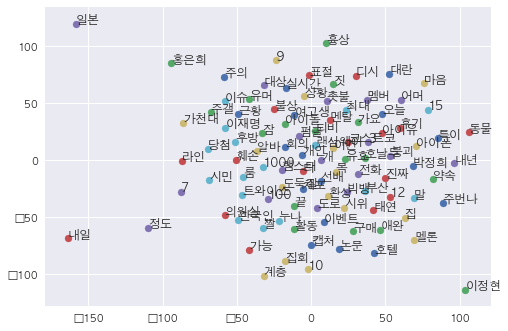

In [16]:
# getting a list of word vectors. limit to 100. each is of 100 dimensions
word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab.keys()]
word_vectors = list(word_vectors)[:100]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:100]

import matplotlib
matplotlib.rc('font', family='AppleGothic')

i = 0
for i in range(tsne_df['words'].size):
    plt.scatter(tsne_df['x'][i], tsne_df['y'][i])
    plt.annotate(tsne_df['words'][i],
                 xy=(tsne_df['x'][i],tsne_df['y'][i]))

plt.show()

t-SNE의 값은 PCA와 달리 지나치게 랜덤하게 변해서 올바른 현상인지 확인이 필요하다.

In [17]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=2)
matrix = vectorizer.fit_transform([x.words for x in x_train])
matrix.shape

building tf-idf matrix ...


(5285, 2585)

In [18]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 2585


In [19]:
tfidf['문재인']

5.0954802806860284

In [20]:
tfidf['박근혜']

4.5756048214001197

In [21]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [22]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in map(lambda x: x.words, x_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in map(lambda x: x.words, x_test)])
test_vecs_w2v = scale(test_vecs_w2v)

train_vecs_w2v.shape

(5285, 200)

In [23]:
test_v = {}
test_tfidf = {}

test_v['A'] = np.array([0.1, 0.4])
test_v['B'] = np.array([0.2, 0.3])
test_v['C'] = np.array([0.3, 0.9])

test_tfidf['A'] = 4
test_tfidf['B'] = 10
test_tfidf['C'] = 7

def testBuildWordVector(tokens, size):
    vec = np.zeros(size).reshape(1,size)
    count = 0.
    for word in tokens:
        # token에 해당하는 벡터에 tfidf 가중치 부여하여 합산
        vec += test_v[word].reshape(1,size) * test_tfidf[word]
        count += 1.

    # token 수 만큼 나누어 1 token 기준 벡터 값 추출
    vec /= count
    
    return vec
    # vec

# 각 벡터를 하나의 numpy array로 join
test_v = np.concatenate([testBuildWordVector(z, 2) for z in [['A', 'B', 'C'], ['C']]])
test_v

array([[ 1.5       ,  3.63333333],
       [ 2.1       ,  6.3       ]])

# Just regular densely-connected NN layer

In [24]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_vecs_w2v, y_train, epochs=120, batch_size=32, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

Widget Javascript not detected.  It may not be installed or enabled properly.


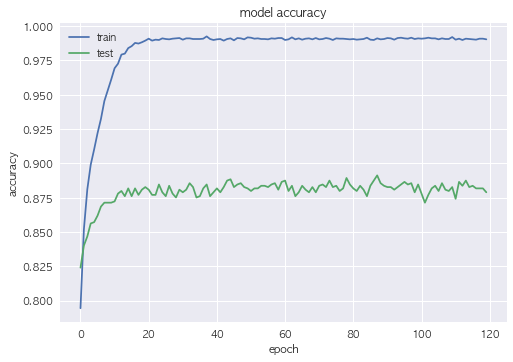

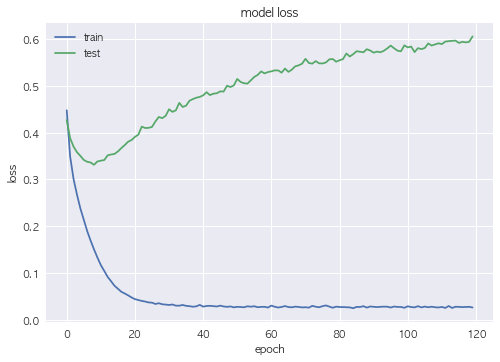

In [26]:
plot_history(history)

In [27]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
score # score[1] is accuracy

[0.5590548170857278, 0.88577912290229743]

In [28]:
train_vecs_w2v.shape

(5285, 200)

In [29]:
train_vecs_w2v = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
train_vecs_w2v.shape, y_train.shape

((5285, 200, 1), (5285,))

In [30]:
test_vecs_w2v = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)
test_vecs_w2v.shape

(1322, 200, 1)

# 1D convolution layer

In [31]:
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D
from keras.layers.normalization import BatchNormalization

model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters=128, kernel_size=3, activation='relu',
                 input_shape=[200,1]))
model.add(MaxPooling1D(4))

model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(4))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(4))

model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)           65664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 128)            82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [32]:
history = model.fit(train_vecs_w2v, y_train,
                    batch_size=32,
                    epochs=40,
                    verbose=0,
                    validation_data=(test_vecs_w2v, y_test),
                    callbacks=[TQDMNotebookCallback(show_inner=False)])

Widget Javascript not detected.  It may not be installed or enabled properly.


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


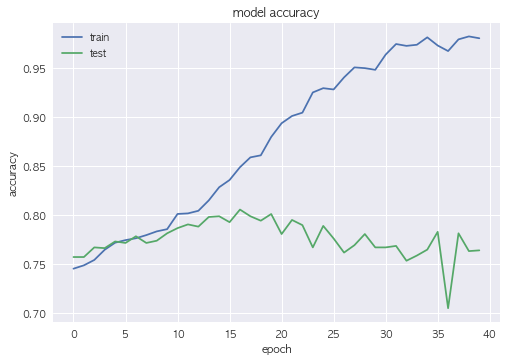

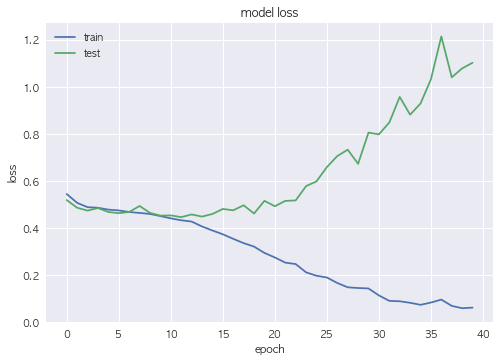

In [33]:
plot_history(history)

In [34]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
score # score[1] is accuracy

[1.1015019422219487, 0.76399394820208988]

In [35]:
model.metrics_names

['loss', 'acc']